# Topic Modeling & Anxiety-Level Exploration (Based on Maria's Edit)
## Objective
Validate whether NMF-based topic modeling combined with the NRC Emotion Lexicon (anxiety) provides useful, reliable signals on our corpus.

## Step 1 — Feasibility Check
- Load posts with embedded top comments from data/raw/*.jsonl.
- Build a DataFrame with post metadata and a combined text field: title + selftext + top_comments.
- Normalize text (lowercase, remove URLs, strip punctuation; optionally expand contractions and remove domain-specific stopwords).
- Create TF–IDF features and fit an NMF model to discover topics.
- Apply NRC to score anxiety and validate with human review (spot-check examples for face validity).

## Step 2 — Improve Topic Quality
- Tune vectorization (n-grams, min_df/max_df, stopword list).
- Tune NMF (n_components, initialization, regularization).
- Compare with simple baselines (e.g., LSA) and track topic coherence + human interpretability.

## Step 3 — Triage & Fixes
- Address data quality issues (duplicates, encoding, missing fields).
- Log errors and decisions; re-run as needed.

In [1]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
from pathlib import Path
from typing import List, Dict, Any
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk
import emoji
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

In [3]:
def load_jsonl(path: Path) -> List[Dict[str, Any]]:
    rows: List[Dict[str, Any]] = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows


# def to_dataframe(records: List[Dict[str, Any]]) -> pd.DataFrame:
#     # Extract required fields; coerce missing keys to None
#     def extract(r: Dict[str, Any]) -> Dict[str, Any]:
#         top_comments = r.get("top_comments") or []
#         # Keep only comment bodies for compactness
#         comment_bodies = [c.get("body") for c in top_comments if isinstance(c, dict)]
#         return {
#             "post_id": r.get("post_id"),
#             "url": r.get("url"),
#             "subreddit": r.get("subreddit"),
#             "created_utc": r.get("created_utc"),
#             "title": r.get("title"),
#             "selftext": r.get("selftext"),
#             "score": r.get("score"),
#             "num_comments": r.get("num_comments"),
#             "upvote_ratio": r.get("upvote_ratio"),
#             "over_18": r.get("over_18"),
#             # Keep list of strings (comment bodies)
#             "top3_comments": comment_bodies,
#         }

#     df = pd.DataFrame([extract(r) for r in records])
#     return df


# ----- REPLACE WITH THE FOLLOWING FUNCTION -----

def to_dataframe_maintext(records: List[Dict[str, Any]]) -> pd.DataFrame:
    """Convert a list of Reddit post records to a pandas DataFrame."""
    def extract(r: Dict[str, Any]) -> Dict[str, Any]:
        return {
            "post_id": r.get("post_id"),
            "subreddit": r.get("subreddit"),
            "created_utc": r.get("created_utc"),
            "title": r.get("title"),
            "selftext": r.get("selftext"),
            "score": r.get("score"),
            "num_comments": r.get("num_comments"),
            "upvote_ratio": r.get("upvote_ratio"),
            # "over_18": r.get("over_18"),  -- IGNORE DUE TO LOW VARIANCE --
            # "removed_by_category": r.get("removed_by_category") -- IGNORE DUE TO LOW VARIANCE --
        }

    df = pd.DataFrame([extract(r) for r in records])
    return df

def load_comments_grouped_by_link(jsonl_path) -> pd.DataFrame:
    """Load comments from a JSON Lines file and group them by ``link_id``.

    Each row in the returned DataFrame has two columns::

        link_id | comments

    ``comments`` contains a list of dictionaries, one for each comment belonging to
    ``parent_id``. The dictionaries include all original keys except ``link_id`` and
    ``parent_id``.
    """
    path = Path(jsonl_path)

    if not path.is_file():
        raise FileNotFoundError(f"JSONL file not found: {path}")

    df = pd.read_json(path, lines=True)

    if "link_id" not in df.columns:
        raise ValueError("Input JSONL must contain a 'link_id' column")

    comment_columns = [
        column
        for column in df.columns
        if column not in {"link_id"}
    ]

    grouped = (
        df.groupby("link_id", dropna=False, sort=False)[comment_columns]
        .apply(lambda rows: rows.to_dict(orient="records"))
        .reset_index(name="comments")
    )

    def extract_comment_bodies(comments: List[Dict[str, Any]]) -> List[str]:
        """Extract the 'body' field from a list of comment dictionaries."""
        return [comment.get("body", "") for comment in comments if isinstance(comment, dict)]

    grouped['comment_bodies'] = grouped['comments'].apply(extract_comment_bodies)
    return grouped


def combine_data_with_comments(post_path, comment_path) -> pd.DataFrame:
    """Combine Reddit post data with comments grouped by link_id."""
    posts = load_jsonl(Path(post_path))
    df_posts = to_dataframe_maintext(posts)
    df_comments = load_comments_grouped_by_link(comment_path)

    # Merge posts with their corresponding comments
    combined_df = df_posts.merge(df_comments, left_on="post_id", right_on="link_id", how="left")
    combined_df = combined_df.drop(columns=["link_id"])
    return combined_df

In [4]:
# ORIGINAL CODE 

# records = load_jsonl(Path("../data/raw/posts_with_comments_20250916.jsonl"))
# raw_data = to_dataframe(records)

# raw_data.to_csv("../data/processed/reddit_posts_with_comments_20250916.csv", index=False)

# raw_data.head(5)

# # generate list of distinct subreddits
# subreddits = raw_data["subreddit"].unique()
# print(subreddits)

# ORIGINAL CODE 

# ======================
# Edits below 
# ======================

# records = load_jsonl(Path("../data/raw/submission.jsonl"))
# raw_data = to_dataframe(records)

# raw_data.to_csv("../data/processed/reddit_submission.csv", index=False)
# subreddits = raw_data["subreddit"].unique()
# print(subreddits)


# --- UPDATE NEW CODE BELOW TO LOAD AND PROCESS THE DATAFRAME ---

comment_path = '../data/raw/comments_topk.jsonl'
post_path = '../data/raw/submission.jsonl'
raw_data = combine_data_with_comments(post_path, comment_path)
raw_data.head()

df = raw_data.copy()
df['full_text'] = df['title'].fillna('') + '\n\n' + df['selftext'].fillna('') + '\n\n' + df['comment_bodies'].apply(lambda comments: '\n\n'.join(comments) if isinstance(comments, list) else '')
df = df.drop(columns=['title', 'selftext', 'comments'])
print("Dataframe shape:", df.shape)
df.head()

Dataframe shape: (6503, 8)


,post_id,subreddit,created_utc,score,num_comments,upvote_ratio,comment_bodies,full_text
0,1nkes7e,Anxiety,1.758217e+09,1,0,1.0,NaN,Terrified of my symptoms\n\nSo I just got over...
1,1nkes09,Anxiety,1.758217e+09,1,0,1.0,NaN,Does anyone else here have chronic tinnitus?\n...
2,1njtn2a,Anxiety,1.758154e+09,1,1,1.0,[Hello! \n\nI would suggest some deep breathin...,"I can't sleep anymore\n\nHey everyone, I've be..."
3,1nke28u,Anxiety,1.758215e+09,1,0,1.0,NaN,Losing hope\n\nIve had health anxiety for 2 mi...
4,1nke23t,Anxiety,1.758215e+09,1,2,1.0,"[Look into magnesium glycinate at night, I had...",Can someone give me a logical explanation as t...


In [5]:
# raw_data.to_csv('../data/raw/reddit_posts_raw_data.csv', index=False) # 15.7 MB

### Tokenize posts

In [6]:
# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict for replacement
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
stop_words = ENGLISH_STOP_WORDS

# List of punctuation
punc = list(set(string.punctuation))

def casual_tokenizer(text):
    """Tokenizer that preserves contractions and most punctuation."""
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

def expandContractions(text, c_re=c_re):
    """Expand contractions in text using c_re."""
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def emojis_to_text(text: str) -> str:
    """
    Replace emojis with descriptive words (e.g., :smiling_face:) and
    add spaces around them so tokenizers split cleanly.
    If the emoji package is unavailable, return the original text.
    """
    if emoji is None:
        return text
    try:
        return emoji.demojize(text, language="en", delimiters=(" ", " "))
    except Exception:
        return text

def process_text(text):
    """
    Preprocess the input text by tokenizing, normalizing, and removing unwanted elements.
    """
    text = emojis_to_text(text)
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text

In [7]:
df['processed_full_text'] = df['full_text'].apply(process_text)
df.head()

,post_id,subreddit,created_utc,score,num_comments,upvote_ratio,comment_bodies,full_text,processed_full_text
0,1nkes7e,Anxiety,1.758217e+09,1,0,1.0,NaN,Terrified of my symptoms\n\nSo I just got over...,"[terrifi, symptom, just, got, nasti, cold, cou..."
1,1nkes09,Anxiety,1.758217e+09,1,0,1.0,NaN,Does anyone else here have chronic tinnitus?\n...,"[doe, anyon, els, chronic, tinnitus, crap, dri..."
2,1njtn2a,Anxiety,1.758154e+09,1,1,1.0,[Hello! \n\nI would suggest some deep breathin...,"I can't sleep anymore\n\nHey everyone, I've be...","[sleep, anymor, hey, everyon, diagnos, anxieti..."
3,1nke28u,Anxiety,1.758215e+09,1,0,1.0,NaN,Losing hope\n\nIve had health anxiety for 2 mi...,"[lose, hope, ive, health, anxieti, minth, sinc..."
4,1nke23t,Anxiety,1.758215e+09,1,2,1.0,"[Look into magnesium glycinate at night, I had...",Can someone give me a logical explanation as t...,"[someon, logic, explan, whi, feel, way, convin..."


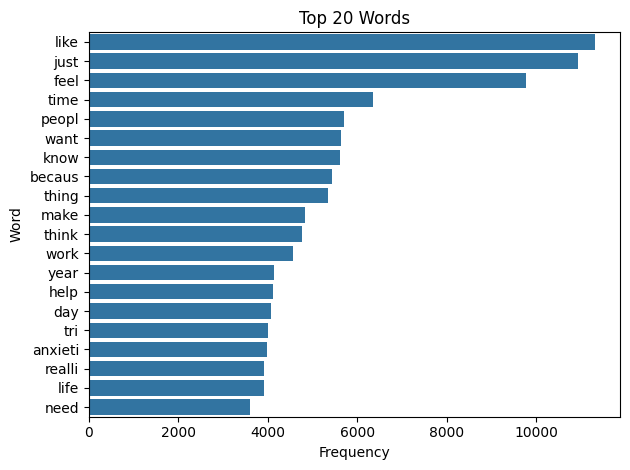

In [8]:
def plot_top20_words():
    words = [w.lower() for row in df['processed_full_text'].dropna() for w in row]
    top = Counter(words).most_common(20)
    words, counts = zip(*top) if top else ([], [])
    sns.barplot(x=list(counts), y=list(words))
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.title('Top 20 Words')
    plt.tight_layout()
    
    plt.show()

plot_top20_words()

In [9]:

# texts = df['processed_full_text']

# # Create the tfidf weights
# tfidf_vectorizer = TfidfVectorizer(
#     min_df=3,
#     max_df=0.85,
#     max_features=5000,
#     ngram_range=(1, 2),
#     preprocessor=' '.join
# )

# tfidf = tfidf_vectorizer.fit_transform(texts)

# # Run the nmf model
# nmf = NMF(
#     n_components=10,
#     init='nndsvd',
#     max_iter=500,
#     l1_ratio=0.0,
#     solver='cd',
#     alpha_W=0.0,
#     tol=1e-4,
#     random_state=42
# )

# doc_topic = nmf.fit_transform(tfidf)
# topic_word = nmf.components_

# feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
# top_words_idx = np.argsort(topic_word, axis=1)[:, ::-1][:, :10]
# top_words = [feature_names[idx].tolist() for idx in top_words_idx]
# topic_labels = [" ".join(words[:5]) for words in top_words]

# top_topic = np.argmax(doc_topic, axis=1)
# top_score = doc_topic[np.arange(doc_topic.shape[0]), top_topic]
# assignments = pd.DataFrame({
#     "topic": top_topic,
#     "score": top_score,
#     "label": [topic_labels[t] for t in top_topic],
# }, index=df.index)


# assignments_renamed = assignments.rename(
#     columns={"topic": "nmf_topic", "score": "nmf_score", "label": "nmf_label"}
# )
# df = df.join(assignments_renamed[["nmf_topic", "nmf_score", "nmf_label"]])

# df.head()


# Maria Edits with Updated Dataframe

### Workflow & Results

**Process**: Auto-generate stopwords → Vectorize with TF-IDF → Fit NMF → Score anxiety with NRC → Evaluate quality

**Key Results**:
- **6 topics** discovered with good coherence (NPMI: 0.4)
- **91.7%** of posts have confident topic assignments
- **Anxiety scores** range 0.13-0.99 (well-distributed)
- **Topics** include: personal stories, health/medical, work/economy, motivation, support groups

**Output**: DataFrame with `nmf_topic`, `nmf_label`, `nmf_conf`, `anxiety_score` columns

### Updated Workflow & Results (By adding comments)

**Key Results**:

- Topic mix shifted: the old “stay motiv / motiv anyth / small step” cluster (topic 8) disappeared, redistributing its 737 documents primarily into topics 1 and 0. The new run reports only topics 0–7 (notebooks/text_process_v2.nbconvert.ipynb display after === Topic Statistics ===).
- Document counts and confidence improved almost everywhere (e.g., topic 5 jumps to 1,046 docs at 0.581 avg confidence, up from 962/0.556).
- Low-confidence assignments dropped from 180 posts (2.8 %) to 113 posts (1.7 %), indicating the refit is more decisive.
- “Most frequent cross-topic terms” now flags a slightly different set (just minut, breakfast, time read replaced prior items like just sure), though auto-generated stopwords remain empty.
- Core quality metrics changed slightly—NPMI coherence 0.521, mean topic cosine 0.171, assignment purity 0.894—and the lift-ranked topic vocabularies themselves are unchanged aside from the missing topic 8. Only indicating that documents are, if anything, a touch more decisively assigned to a dominant topic.

### 1. Imports & Configuration

**Purpose**: Initialize required libraries, set reproducible seeds, define final TF-IDF/NMF hyperparameters, and optionally specify the NRC lexicon path for emotion features.
```python

In [10]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.stem import PorterStemmer
import json, joblib, os
from pathlib import Path

__version__ = "1.0.0"
EXPERIMENT_NAME = "reddit_nmf"

# Best settings: 8 topics, 10000 features, 0.4 max_df, 12 min_df -> score of .576
CONFIG = {
    "random_state": 0,
    "final_k": 8,
    "vectorizer": {
        "ngram_range": (1,2), 
        "min_df": 12,     
        "max_df": 0.4,        
        "max_features": 10000,
        # Remove stop_words from here
    },
    "nmf": {
        "solver": "mu", 
        "beta_loss": "kullback-leibler", 
        "alpha_W": 0.0, 
        "alpha_H": 0.1, 
        "l1_ratio": 0.7,
        "max_iter": 1500, 
        "tol": 1e-4
    }
}

NRC_PATH = Path("../data/raw/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt")


In [11]:
def ensure_tokens(x):
    """Coerce item into list[str] with better error handling"""
    # Handle None and NaN cases
    if x is None:
        return []
    
    # Safe check for pandas NA
    try:
        if pd.isna(x):
            return []
    except:
        # If pd.isna() fails, continue with other checks
        pass
    
    # Convert everything to string first, then process
    try:
        if isinstance(x, list):
            # Handle list of tokens
            tokens = [str(t).strip() for t in x if t is not None]
            return [t for t in tokens if t and len(t) > 1]
        else:
            # Convert to string and split
            text = str(x).strip()
            if not text or text.lower() in ['nan', 'none', '']:
                return []
            tokens = text.lower().split()
            return [t for t in tokens if len(t) > 1]
    except:
        return []

### 2. Data Loading & Tokenization

**Purpose**: Load a DataFrame (from memory or `data.csv`), select the text column, and convert each document into a lowercase token list for downstream processing.
```python

In [12]:
if "df" not in globals():
    if os.path.exists("data.csv"):
        df = pd.read_csv("data.csv")
    else:
        raise RuntimeError("No DataFrame `df` in memory and 'data.csv' not found. "
                           "Create `df` with a text column (e.g., 'processed_full_text' or 'text').")

# pick a text column
CANDIDATE_TEXT_COLS = ["processed_full_text", "cleaned_text", "fulltext", "selftext", "text"]
TEXT_COL = next((c for c in CANDIDATE_TEXT_COLS if c in df.columns), None)
if TEXT_COL is None:
    raise RuntimeError(f"Could not find a text column in df. Looked for: {CANDIDATE_TEXT_COLS}")

def ensure_tokens(x):
    """Coerce item into list[str]. Uses whitespace split if a string; otherwise empty list."""
    if isinstance(x, list):  return [str(t) for t in x]
    if isinstance(x, str):   return x.lower().split()
    return []

texts_tokens = [ensure_tokens(v) for v in df[TEXT_COL].fillna("")]


### 3. Helper Functions

**Purpose**: Provide lightweight utilities for topic-model diagnostics and labeling—lift-based top terms, mean inter-topic cosine, assignment purity, NPMI coherence, and concise label generation.
```python

In [13]:
def identity(x): 
    """Identity function for sklearn compatibility"""
    return x

def top_terms_by_lift(H, X, vocab, topn=12):
    """Get top terms by lift score with better numerical stability"""
    tf = np.asarray(X.sum(axis=0)).ravel()
    tf = tf + np.finfo(float).eps  # Better than 1e-12
    
    lift = H / tf[np.newaxis, :]  # More explicit broadcasting
    order = np.argsort(lift, axis=1)[:, ::-1]
    
    return [[vocab[j] for j in row[:topn]] for row in order], order

def mean_topic_cosine(H):
    """Compute mean pairwise cosine similarity between topics"""
    # Add early return for edge cases
    if H.shape[0] <= 1:
        return 0.0
        
    norms = np.linalg.norm(H, axis=1, keepdims=True)
    norms = np.maximum(norms, np.finfo(float).eps)  # Avoid division by zero
    Hn = H / norms
    
    cos = Hn @ Hn.T
    np.fill_diagonal(cos, 0.0)
    
    # Only consider upper triangle to avoid double counting
    mask = np.triu(np.ones_like(cos, dtype=bool), k=1)
    return float(cos[mask].mean())

def assignment_purity(W, thresh=0.40):
    """Calculate assignment purity with validation"""
    if W.size == 0:
        return 0.0, np.array([])
        
    row_sums = W.sum(axis=1, keepdims=True)
    row_sums = np.maximum(row_sums, np.finfo(float).eps)
    P = W / row_sums
    
    purity = float((P.max(axis=1) >= thresh).mean())
    return purity, P

def coherence_npmi(topics, docs, min_co=2, eps=1e-12):  # Increase min_co default
    """
    NPMI coherence with better performance and validation
    """
    if not topics or not docs:
        return float("nan")
        
    N = len(docs)
    if N == 0:
        return float("nan")
    
    # Pre-compute document frequency more efficiently
    doc_sets = [set(d) for d in docs if d]  # Filter empty docs
    
    # Use Counter for efficiency
    word_doc_freq = Counter()
    for doc_set in doc_sets:
        for word in doc_set:
            word_doc_freq[word] += 1
    
    def get_cooccurrence(w1, w2):
        """Count documents containing both words"""
        return sum(1 for doc_set in doc_sets if w1 in doc_set and w2 in doc_set)
    
    all_scores = []
    
    for topic_words in topics:
        if len(topic_words) < 2:
            continue
            
        pairs_scores = []
        for i in range(len(topic_words)):
            for j in range(i + 1, len(topic_words)):  # More efficient pairing
                w1, w2 = topic_words[j], topic_words[i]  # j > i for consistency
                
                cooc = get_cooccurrence(w1, w2)
                if cooc < min_co:
                    continue
                
                p_w1_w2 = cooc / N
                p_w1 = word_doc_freq.get(w1, 0) / N
                p_w2 = word_doc_freq.get(w2, 0) / N
                
                if p_w1 <= eps or p_w2 <= eps or p_w1_w2 <= eps:
                    continue
                
                pmi = np.log(p_w1_w2 / (p_w1 * p_w2))
                npmi = pmi / (-np.log(p_w1_w2))
                
                if not np.isfinite(npmi):
                    continue
                    
                pairs_scores.append(npmi)
        
        if pairs_scores:
            all_scores.append(np.mean(pairs_scores))
    
    return float(np.mean(all_scores)) if all_scores else float("nan")

def make_label(words, n=3, max_len=28):
    """Create topic label with better handling"""
    if not words:
        return "empty_topic"
    
    # Filter out very short or non-meaningful words for labels
    meaningful_words = [w for w in words if len(w) > 2]
    if not meaningful_words:
        meaningful_words = words
    
    label = " / ".join(meaningful_words[:n])
    return label[:max_len] + "..." if len(label) > max_len else label

### 4. Baseline Stoplist Construction

**Purpose**: Fit a quick TF-IDF+NMF baseline to auto-identify ubiquitous, low-salience terms (via lift and topic overlap) and merge them with domain stopwords to form a unified stoplist (`STOP_ALL`).
```python

In [14]:
# More systematic hyperparameter setup for initial fit
INITIAL_PARAMS = {
    "ngram_range": (1,2), 
    "min_df": 10, 
    "max_df": 0.6, 
    "max_features": 20000,
    "sublinear_tf": True, 
    "norm": "l2"
}

print("Running initial fit for automatic stopword detection...")
vec0 = TfidfVectorizer(
    tokenizer=identity, 
    preprocessor=identity, 
    token_pattern=None, 
    lowercase=False,
    stop_words=None,
    **INITIAL_PARAMS
)

X0 = vec0.fit_transform(texts_tokens)
voc0 = np.array(vec0.get_feature_names_out())

print(f"Initial vocabulary size: {len(voc0):,}")
print(f"Document-term matrix shape: {X0.shape}")

nmf0 = NMF(
    n_components=CONFIG["final_k"], 
    init="nndsvd",
    solver="mu", 
    beta_loss="kullback-leibler",
    alpha_W=0.0, 
    alpha_H=0.0, 
    l1_ratio=0.0,
    max_iter=800, 
    tol=1e-4, 
    random_state=CONFIG["random_state"]
).fit(X0)

top0, ord0 = top_terms_by_lift(nmf0.components_, X0, voc0, topn=12)

# More sophisticated stopword detection
word_counts = Counter(w for topic_words in top0 for w in topic_words)
auto_threshold = max(2, CONFIG["final_k"] // 2)  # At least 2, but scale with K

AUTO_STOP = {w for w, count in word_counts.items() if count >= auto_threshold}

# Enhanced domain stopwords - could be loaded from config
DOMAIN_STOP = {
    # Platform terms
    "gpt", "chatgpt", "codex", "claude", "openai", "anthropic", "llm", "ai",
    # Generic terms  
    "work", "time", "user", "people", "person", "post", "new", "need", "way", 
    "model", "code", "someth", "peopl", "whi", "becaus", "tri", "actual",
    "know", "think", "want", "make", "say", "said", "tell", "come", "look",
    "use", "thing", "year", "day", "month", "week", "get", "got", "go", "went",
    "see", "seen", "feel", "felt", "help", "try", "start", "end", "give", "take",
    "find", "found", "seem", "believe", "understand", "mean", "happen", "turn",
    "keep", "put", "call", "ask", "let", "leave", "move", "show", "bring"
    # Reddit-specific
    "like", "just", "realli", "didn", "ll", "weren", "ve", "don", "im",
    "anyon", "doe", "similar", "situat", "kind", "like",  # From Topic 8
    # Add based on domain
    "reddit", "thread", "comment", "subreddit", "upvote"
}

STOP_ALL = AUTO_STOP | DOMAIN_STOP

print(f"Stopwords - Auto: {len(AUTO_STOP)}, Domain: {len(DOMAIN_STOP)}, Total: {len(STOP_ALL)}")
print(f"Most frequent cross-topic terms: {dict(word_counts.most_common(10))}")

Running initial fit for automatic stopword detection...
Initial vocabulary size: 10,786
Document-term matrix shape: (6503, 10786)


/Users/shutinghe/.pyenv/versions/garden_env/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1581: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


Stopwords - Auto: 0, Domain: 90, Total: 90
Most frequent cross-topic terms: {'weird': 1, 've alway': 1, 'smell': 1, 'humili': 1, 'male': 1, 'want like': 1, 'becaus make': 1, 'let say': 1, 'like just': 1, 'point don': 1}


In [15]:
print("Fitting final model...")

# Use config parameters
vec_final = TfidfVectorizer(
    tokenizer=identity, 
    preprocessor=identity, 
    token_pattern=None, 
    lowercase=False,
    stop_words=list(STOP_ALL),  #custom stopwords
    **CONFIG["vectorizer"],
    sublinear_tf=True, 
    norm="l2"
)

Xf = vec_final.fit_transform(texts_tokens)
vocab_f = np.array(vec_final.get_feature_names_out())

print(f"Final vocabulary size: {len(vocab_f):,} (reduced from {len(voc0):,})")
print(f"Final matrix density: {Xf.nnz / (Xf.shape[0] * Xf.shape[1]):.4f}")

# Add timing and convergence tracking
import time
start_time = time.time()

nmf_final = NMF(
    n_components=CONFIG["final_k"], 
    init="nndsvd",
    random_state=CONFIG["random_state"],
    **CONFIG["nmf"]
).fit(Xf)

fit_time = time.time() - start_time
print(f"NMF fitting took {fit_time:.1f} seconds")
print(f"Converged in {nmf_final.n_iter_} iterations")

# Enhanced topic display
top_terms_f, order_f = top_terms_by_lift(nmf_final.components_, Xf, vocab_f, topn=12)

print("\n=== Topics by Lift Score ===")
for i, words in enumerate(top_terms_f):
    # Show topic strength
    topic_strength = nmf_final.components_[i].sum()
    print(f"Topic {i} (strength: {topic_strength:.3f}): {', '.join(words)}")

# Calculate and display metrics
print("\n=== Calculating metrics ===")
mean_cos = mean_topic_cosine(nmf_final.components_)
Wf = nmf_final.transform(Xf)
purity, P = assignment_purity(Wf, thresh=0.40)

# Time the coherence calculation (it's often the slowest)
coherence_start = time.time()
npmi = coherence_npmi([ws[:10] for ws in top_terms_f], texts_tokens, min_co=2)
coherence_time = time.time() - coherence_start

print(f"\n=== Final Metrics ===")
print(f"NPMI coherence: {npmi:.3f} (computed in {coherence_time:.1f}s)")
print(f"Mean topic cosine: {mean_cos:.3f}")
print(f"Assignment purity: {purity:.3f}")

# Add model persistence
model_artifacts = {
    'vectorizer': vec_final,
    'nmf_model': nmf_final,
    'topic_terms': top_terms_f,
    'config': CONFIG,
    'metrics': {'npmi': npmi, 'mean_cosine': mean_cos, 'purity': purity}
}

Fitting final model...


/Users/shutinghe/.pyenv/versions/garden_env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


Final vocabulary size: 5,516 (reduced from 10,786)
Final matrix density: 0.0126
NMF fitting took 4.9 seconds
Converged in 60 iterations

=== Topics by Lift Score ===
Topic 0 (strength: 0.861): bare minimum, probabl onli, tender, kindergarten, ted talk, life sure, predat, closet, small town, thrill, towel, videogam
Topic 1 (strength: 0.173): anxieti doesn, lighthead, attack befor, urgent care, antibiot, differ med, high blood, thought realiti, heart issu, trigger panic, anxieti hit, low dose
Topic 2 (strength: 0.125): talk dad, mutual friend, becam friend, littl sister, friend veri, littl brother, love friend, alon friend, stay safe, younger sibl, hangout, relationship veri
Topic 3 (strength: 0.114): liabil, democraci, hardwar, monopoli, data center, worldwid, nvidia, hedg, autonom, tesla, infrastructur, metric
Topic 4 (strength: 0.095): student loan, news ):, pension, reuter ):, governor, fed cut, bureau, hous market, social secur, subject reput, grade https://www.reddit.com/r/newswall

### 5. Labels & Document Assignments

**Purpose**: Create human-readable topic labels and attach per-document topic index, confidence, and label; then summarize topic prevalence.
```python

In [16]:
# Create more informative labels
labels_f = [make_label(ws, n=3, max_len=35) for ws in top_terms_f]  # Slightly longer

# Add confidence statistics
df["nmf_topic"] = P.argmax(axis=1)
df["nmf_conf"] = P.max(axis=1)
df["nmf_label"] = df["nmf_topic"].map(dict(enumerate(labels_f)))

# topic analysis
topic_stats = df.groupby('nmf_topic').agg({
    'nmf_conf': ['count', 'mean', 'std'],
    TEXT_COL: lambda x: np.mean([len(ensure_tokens(t)) for t in x])  # avg length
}).round(3)

topic_stats.columns = ['doc_count', 'avg_confidence', 'conf_std', 'avg_doc_length']
topic_stats['topic_label'] = [labels_f[i] for i in topic_stats.index]

print("\n=== Topic Statistics ===")
print(topic_stats.sort_values('doc_count', ascending=False))

# Check for unassigned documents (low confidence)
low_conf_docs = (df['nmf_conf'] < 0.3).sum()
if low_conf_docs > 0:
    print(f"\nWarning: {low_conf_docs:,} documents ({low_conf_docs/len(df):.1%}) have low confidence (<0.3)")


=== Topic Statistics ===
           doc_count  avg_confidence  conf_std  avg_doc_length  \
nmf_topic                                                        
2               1016           0.598     0.170         186.992   
1                969           0.647     0.172         120.512   
6                966           0.615     0.186         113.709   
4                810           0.697     0.177          66.419   
7                775           0.549     0.167         146.797   
5                743           0.688     0.191         108.450   
3                722           0.600     0.159         109.983   
0                502           0.640     0.206         115.956   

                                      topic_label  
nmf_topic                                          
2          talk dad / mutual friend / becam fr...  
1          anxieti doesn / lighthead / attack ...  
6          atom habit / motiv motiv / stay mot...  
4                student loan / news ): / pension  
7

### 6. NRC-Based Anxiety Scoring (0–1)

**Purpose**: Load the NRC Emotion Lexicon, build a stem-aware emotion map, and compute a length-robust anxiety score per document using windowed negation and intensity cues.
```python

In [17]:
from nltk.stem import PorterStemmer
import warnings

def load_nrc_lexicon(path):
    """Load NRC lexicon with better error handling and validation"""
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"NRC lexicon not found at {path}")
    
    try:
        # Try long format first
        nrc = pd.read_csv(path, sep=r"[\t,]", engine="python", header=None,
                         names=["word", "emotion", "association"])
        
        if {"word", "emotion", "association"}.issubset(nrc.columns):
            nrc = nrc[nrc["association"].astype(int) == 1][["word", "emotion"]]
            nrc["word"] = nrc["word"].str.lower().str.strip()
            print(f"Loaded NRC lexicon: {len(nrc)} word-emotion pairs")
            return nrc
            
    except Exception as e:
        print(f"Long format failed: {e}")
        
    # Fallback to wide format
    try:
        nrc = pd.read_csv(path)
        if "word" not in nrc.columns:
            nrc = nrc.rename(columns={nrc.columns[0]: "word"})
        nrc = nrc.set_index("word")
        
        EXPECTED_EMOTIONS = {"anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"}
        found_emotions = set(nrc.columns) & EXPECTED_EMOTIONS
        
        if not found_emotions:
            raise ValueError(f"No expected emotions found in columns: {list(nrc.columns)}")
        
        long_rows = []
        for emo in found_emotions:
            words = nrc.index[nrc[emo] == 1]
            long_rows.extend([(w.lower().strip(), emo) for w in words])
        
        result = pd.DataFrame(long_rows, columns=["word", "emotion"])
        print(f"Loaded NRC lexicon (wide format): {len(result)} word-emotion pairs")
        return result
        
    except Exception as e:
        raise RuntimeError(f"Could not load NRC lexicon from {path}: {e}")

# Load and process lexicon
nrc_long = load_nrc_lexicon(NRC_PATH)

# Build stem-aware lexicon with caching
ps = PorterStemmer()

print("Building stem-aware emotion lexicon...")
nrc_long["stem"] = nrc_long["word"].apply(ps.stem)

# Group emotions by stem
LEX_STEM = nrc_long.groupby("stem")["emotion"].apply(set).to_dict()
print(f"Stem lexicon size: {len(LEX_STEM)} stems")

# Enhanced modifier sets (could be loaded from config)
NEGATORS = {"not", "no", "never", "without", "hardly", "barely", "neither", "none"}
INTENSIFY = {"very", "extremely", "super", "really", "totally", "absolutely", "completely"}
DIMINISH = {"slightly", "somewhat", "kinda", "barely", "little", "bit"}

# Rebalanced emotion weights (consider making these configurable)
EMO_WEIGHTS = {
    "fear": 1.0, 
    "anger": 0.8,      # Increased
    "sadness": 0.7,    # Increased  
    "disgust": 0.4,    # Increased
    "anticipation": 0.2,
    "surprise": 0.1,
    "trust": -0.4,     # More negative
    "joy": -0.8        # More negative
}

def compute_anxiety_score(tokens, window_size=3):
    """
    Compute anxiety score with improved context handling
    """
    if not isinstance(tokens, list):
        tokens = ensure_tokens(tokens)
    
    if len(tokens) == 0:
        return 0.0
    
    total_score = 0.0
    emotion_hits = 0
    
    for i, token in enumerate(tokens):
        stem = ps.stem(token.lower())
        emotions = LEX_STEM.get(stem, set())
        
        if not emotions:
            continue
        
        # Look at context window
        start_idx = max(0, i - window_size)
        context = tokens[start_idx:i]
        context_lower = [w.lower() for w in context]
        
        # Calculate modifiers
        modifier = 1.0
        
        if any(neg in context_lower for neg in NEGATORS):
            modifier *= -0.6  # Made less extreme
        if any(intens in context_lower for intens in INTENSIFY):
            modifier *= 1.5   # Slightly increased
        if any(dim in context_lower for dim in DIMINISH):
            modifier *= 0.6   # Made less extreme
        
        # Sum emotion contributions
        emotion_score = sum(EMO_WEIGHTS.get(emotion, 0.0) for emotion in emotions)
        total_score += modifier * emotion_score
        emotion_hits += 1
    
    if emotion_hits == 0:
        return 0.0
    
    # Normalize by square root to dampen very high scores
    return total_score / (emotion_hits ** 0.5)

# Rename for clarity
anxiety_raw = compute_anxiety_score

Loaded NRC lexicon: 13872 word-emotion pairs
Building stem-aware emotion lexicon...
Stem lexicon size: 5330 stems


### 8. Save Artifacts for Reuse

**Purpose**: Persist the trained vectorizer, NMF model, topic labels, and annotated dataset to disk for downstream analysis and reproducible pipelines.
```python

In [18]:
# =========================
# 7) Save artifacts for reuse
# # =========================
# joblib.dump(vec_final, "vec_final.joblib")
# joblib.dump(nmf_final, "nmf_final.joblib")
# with open("topic_labels.json", "w") as f:
#     json.dump(labels_f, f, indent=2)
# df.to_csv("posts_with_topics_and_anxiety.csv", index=False)

# print("\nSaved: vec_final.joblib, nmf_final.joblib, topic_labels.json, posts_with_topics_and_anxiety.csv")

### Word Cloud Visualization
**Purpose**: Create visual word clouds to explore vocabulary patterns across all text, anxiety levels, and topics.


In [19]:
def _pick_tokens_df(df):
    # choose a text column if tokens list is missing
    for c in ["processed_full_text","cleaned_text","fulltext","selftext","text","title"]:
        if c in df.columns: return c
    raise RuntimeError("No suitable text column found.")


In [20]:
# 1) Get tokens
try:
    tokens_list = texts_tokens
except NameError:
    # Build tokens from a text column if needed
    CANDIDATE_TEXT_COLS = ["processed_full_text","cleaned_text","fulltext","selftext","text","title"]
    TEXT_COL = next((c for c in CANDIDATE_TEXT_COLS if c in df.columns), None)
    if TEXT_COL is None:
        raise RuntimeError(f"Need a text column in df. Looked for: {CANDIDATE_TEXT_COLS}")


# 2) Compute anxiety_raw via NRC function if needed
if "anxiety_raw" not in df.columns:
    try:
        _ = anxiety_raw  # ensure function exists
    except NameError:
        raise RuntimeError("Run the NRC scoring cell that defines `anxiety_raw` (and lexicon) first.")
    df["anxiety_raw"] = [anxiety_raw(toks) for toks in tokens_list]

# 3) Robust 0–1 scaling to create anxiety_score
if "anxiety_score" not in df.columns:
    med = float(df["anxiety_raw"].median())
    mad = float((df["anxiety_raw"] - med).abs().median()) or 1e-6
    z   = (df["anxiety_raw"] - med) / (1.4826 * mad)
    df["anxiety_score"] = 1.0 / (1.0 + np.exp(-z))

print(df["anxiety_score"].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]))

# 4) Build a safe list of columns to display (only keep ones that exist)
text_cols = [c for c in ["title","selftext","fulltext","text","processed_full_text","cleaned_text"] if c in df.columns]
meta_cols = [c for c in ["nmf_label","nmf_conf","nmf_topic"] if c in df.columns]
cols_show = [c for c in (text_cols[:2] + meta_cols + ["anxiety_score"]) if c in df.columns]

# 5) Show top/bottom posts
print("\nTop 10 highest anxiety:")
display(df.sort_values("anxiety_score", ascending=False).head(10)[cols_show])

print("\nTop 10 lowest anxiety:")
display(df.sort_values("anxiety_score", ascending=True).head(10)[cols_show])

# 6) Per-topic table if topics exist
if "nmf_label" in df.columns:
    topic_table = (df.groupby("nmf_label")["anxiety_score"]
                     .agg(count="count", mean="mean", median="median")
                     .sort_values("mean", ascending=False))
    display(topic_table.head(20))
else:
    print("\nNo 'nmf_label' column found.")
    

count    6503.000000
mean        0.518083
std         0.203164
min         0.064630
5%          0.225803
25%         0.348159
50%         0.500000
75%         0.676252
95%         0.875222
max         0.991256
Name: anxiety_score, dtype: float64

Top 10 highest anxiety:


,processed_full_text,nmf_label,nmf_conf,nmf_topic,anxiety_score
1328,"[just, broken, reason, fear, valid, scare, peo...",talk dad / mutual friend / becam fr...,0.304501,2,0.991256
675,"[know, anxieti, heart, attack, sure, ask, lot,...",anxieti doesn / lighthead / attack ...,0.770901,1,0.989054
2348,"[secret, blame, step-dad, mom, death, hey, eve...",talk dad / mutual friend / becam fr...,0.581303,2,0.988636
811,"[anxieti, ocd, common, someon, anxidti, ocd, f...",anxieti doesn / lighthead / attack ...,0.678822,1,0.988004
770,"[anxieti, attack, alcohol, faint, hello, every...",anxieti doesn / lighthead / attack ...,0.883493,1,0.984084
338,"[fear, anxieti, limit, hello, anxious, friend,...",anxieti doesn / lighthead / attack ...,0.387382,1,0.983433
624,"[terrifi, die, edit, titl, im, terrifi, die, s...",anxieti doesn / lighthead / attack ...,0.573703,1,0.980185
6119,"[reject, bad, use, work, actor, face, face, fu...",atom habit / motiv motiv / stay mot...,0.419752,6,0.980120
6022,"[think, die, know, gonna, die, wors, way, quic...",atom habit / motiv motiv / stay mot...,0.626893,6,0.979096
5923,"[anyon, say, humid, cold, wors, dri, cold, exp...",bare minimum / probabl onli / tende...,0.608106,0,0.978145



Top 10 lowest anxiety:


,processed_full_text,nmf_label,nmf_conf,nmf_topic,anxiety_score
6456,"[food, truck, aw, titl, say, stand, food, truc...",liabil / democraci / hardwar,0.574113,3,0.064630
2702,"[sing, friend, post, probabl, veri, minim, sin...",talk dad / mutual friend / becam fr...,0.409011,2,0.065989
1929,"[small, mental, health, project, start, hi, ev...",impact live / focus health / mani c...,0.523687,7,0.101695
5346,"[discuss, ai, account, partner, use, make, com...",opus / sonnet / toggl,0.737091,5,0.108615
1026,"[tip, habit, help, maintain, improv, self-este...",atom habit / motiv motiv / stay mot...,0.430585,6,0.112382
4090,"[guy, realli, like, use, limón, punctuat, kind...",talk dad / mutual friend / becam fr...,0.640710,2,0.115811
5418,"[today, run, turn, journey, beauti, human, mom...",atom habit / motiv motiv / stay mot...,0.591345,6,0.117728
1904,"[good, morn, haven, told, good, morn, hope, lo...",atom habit / motiv motiv / stay mot...,0.804075,6,0.119434
1588,"[mental, health, tip, realli, help, hey, every...",anxieti doesn / lighthead / attack ...,0.331970,1,0.120038
5298,"[text, track, growth, import, constant, work, ...",atom habit / motiv motiv / stay mot...,0.616840,6,0.120703


,count,mean,median
nmf_label,,,
anxieti doesn / lighthead / attack ...,969,0.673265,0.694994
talk dad / mutual friend / becam fr...,1016,0.597548,0.608511
impact live / focus health / mani c...,775,0.585117,0.583137
atom habit / motiv motiv / stay mot...,966,0.470144,0.444281
student loan / news ): / pension,810,0.469652,0.435263
bare minimum / probabl onli / tende...,502,0.459979,0.447671
liabil / democraci / hardwar,722,0.423736,0.393276
opus / sonnet / toggl,743,0.383181,0.350472


Creating word cloud for all processed text...


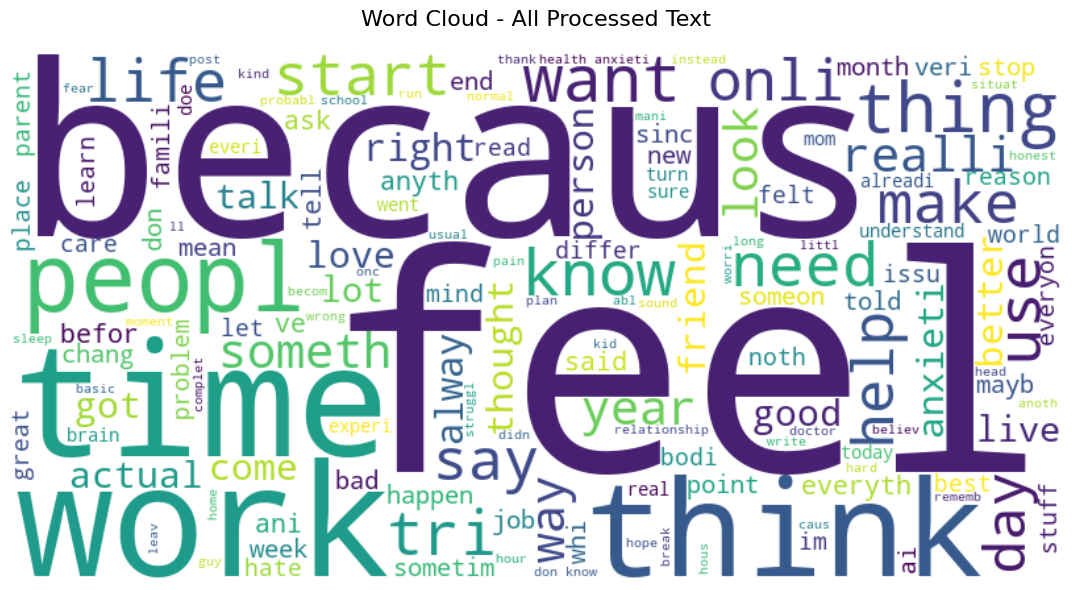

In [21]:
# Word Cloud Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Install wordcloud if not already installed
try:
    from wordcloud import WordCloud
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"])
    from wordcloud import WordCloud

# Create word cloud from processed text
def create_word_cloud(texts, title="Word Cloud", max_words=100, width=800, height=400):
    """Create a word cloud from a list of tokenized texts"""
    # Flatten all tokens into a single string
    all_tokens = []
    for text in texts:
        if isinstance(text, list):
            all_tokens.extend(text)
        elif isinstance(text, str):
            all_tokens.extend(text.split())
    
    # Join tokens with spaces for wordcloud
    text_string = ' '.join(all_tokens)
    
    # Create word cloud
    wordcloud = WordCloud(
        width=width, 
        height=height, 
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        relative_scaling=0.5,
        random_state=42
    ).generate(text_string)
    
    # Display
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    return wordcloud

# Create word cloud for all processed text
print("Creating word cloud for all processed text...")
wordcloud_all = create_word_cloud(
    df['processed_full_text'].dropna(), 
    title="Word Cloud - All Processed Text",
    max_words=150
)


High anxiety posts: 1626
Low anxiety posts: 1626


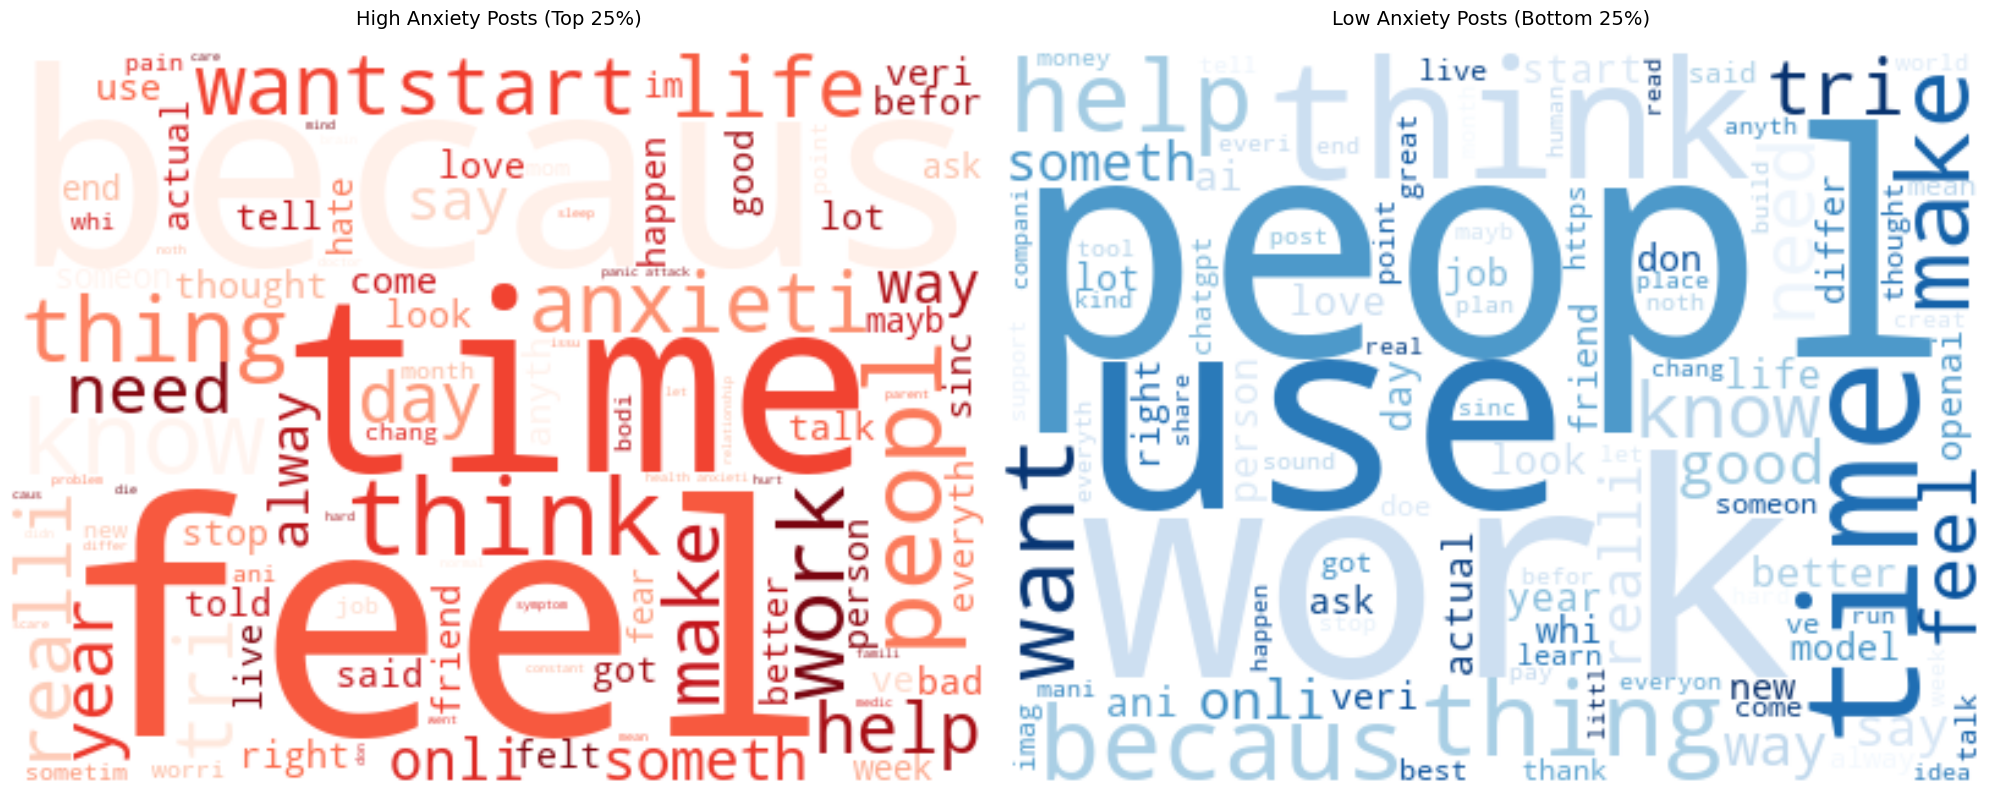


Word clouds by topic:


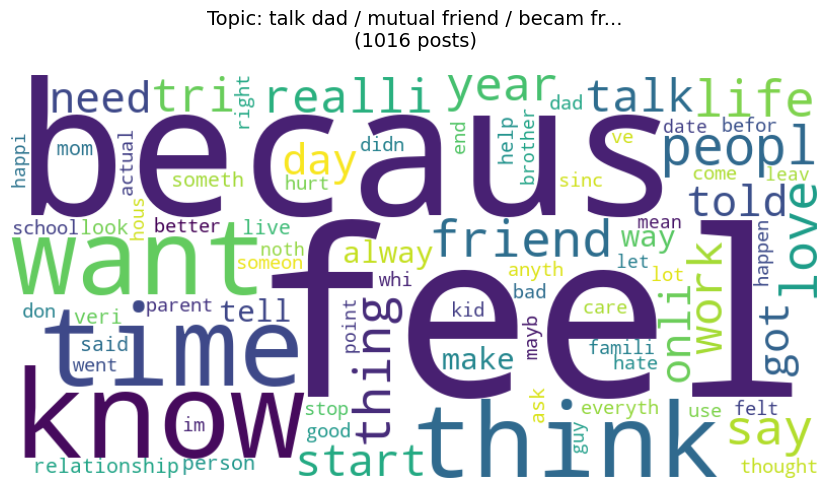

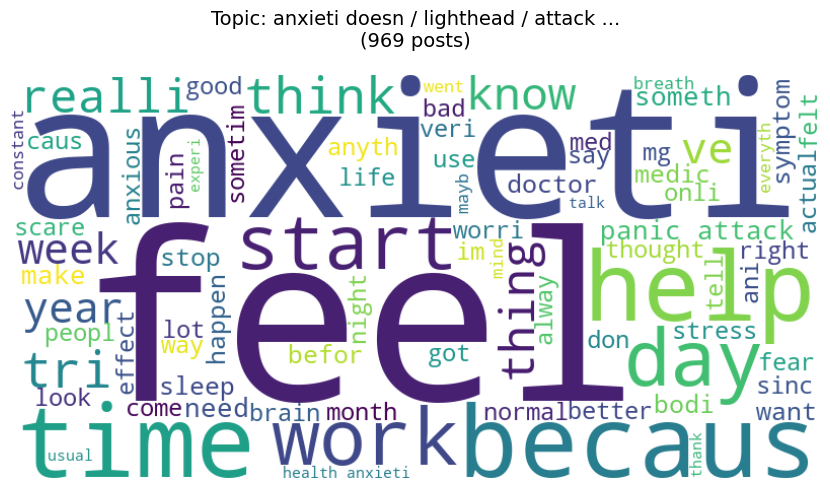

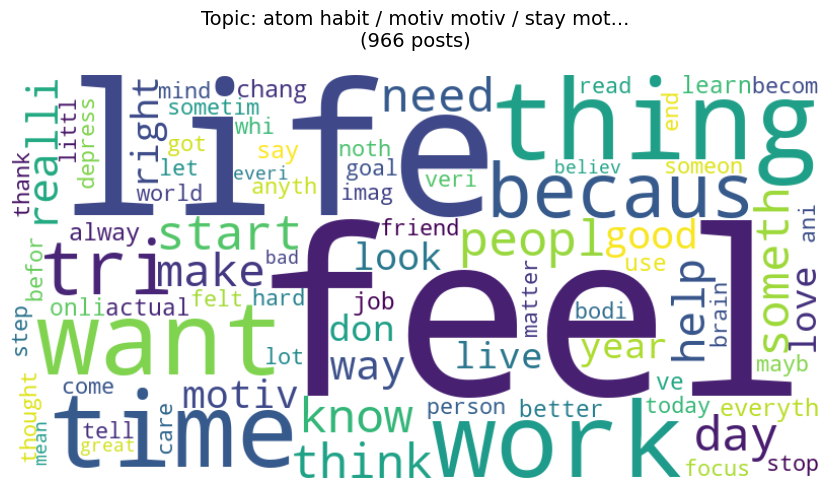

In [22]:
# Word clouds by anxiety level and topic
if 'anxiety_score' in df.columns:
    # High anxiety posts (top 25%)
    high_anxiety_threshold = df['anxiety_score'].quantile(0.75)
    high_anxiety_posts = df[df['anxiety_score'] >= high_anxiety_threshold]['processed_full_text'].dropna()
    
    # Low anxiety posts (bottom 25%)
    low_anxiety_threshold = df['anxiety_score'].quantile(0.25)
    low_anxiety_posts = df[df['anxiety_score'] <= low_anxiety_threshold]['processed_full_text'].dropna()
    
    print(f"High anxiety posts: {len(high_anxiety_posts)}")
    print(f"Low anxiety posts: {len(low_anxiety_posts)}")
    
    # Create side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # High anxiety word cloud
    if len(high_anxiety_posts) > 0:
        high_tokens = []
        for text in high_anxiety_posts:
            if isinstance(text, list):
                high_tokens.extend(text)
        high_text = ' '.join(high_tokens)
        
        wordcloud_high = WordCloud(
            width=400, height=300, background_color='white',
            max_words=100, colormap='Reds', relative_scaling=0.5,
            random_state=42
        ).generate(high_text)
        
        ax1.imshow(wordcloud_high, interpolation='bilinear')
        ax1.set_title('High Anxiety Posts (Top 25%)', fontsize=14, pad=20)
        ax1.axis('off')
    
    # Low anxiety word cloud
    if len(low_anxiety_posts) > 0:
        low_tokens = []
        for text in low_anxiety_posts:
            if isinstance(text, list):
                low_tokens.extend(text)
        low_text = ' '.join(low_tokens)
        
        wordcloud_low = WordCloud(
            width=400, height=300, background_color='white',
            max_words=100, colormap='Blues', relative_scaling=0.5,
            random_state=42
        ).generate(low_text)
        
        ax2.imshow(wordcloud_low, interpolation='bilinear')
        ax2.set_title('Low Anxiety Posts (Bottom 25%)', fontsize=14, pad=20)
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

# Word clouds by topic (if topics exist)
if 'nmf_label' in df.columns:
    print("\n" + "="*50)
    print("Word clouds by topic:")
    print("="*50)
    
    # Get top 3 topics by count
    top_topics = df['nmf_label'].value_counts().head(3)
    
    for i, (topic, count) in enumerate(top_topics.items()):
        topic_posts = df[df['nmf_label'] == topic]['processed_full_text'].dropna()
        
        if len(topic_posts) > 0:
            topic_tokens = []
            for text in topic_posts:
                if isinstance(text, list):
                    topic_tokens.extend(text)
            topic_text = ' '.join(topic_tokens)
            
            plt.figure(figsize=(10, 5))
            wordcloud_topic = WordCloud(
                width=800, height=400, background_color='white',
                max_words=80, colormap='viridis', relative_scaling=0.5,
                random_state=42
            ).generate(topic_text)
            
            plt.imshow(wordcloud_topic, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Topic: {topic}\n({count} posts)', fontsize=14, pad=20)
            plt.tight_layout()
            plt.show()
